# Botnet detection using Network Traffic Classification based on Single Flow Time Series Analysis 

Problem: binary detection of botnet

Raw data from: CTU-13 dataset [1]

-----------------------------------------------------------------------
[1] S. Garc ́ıa et al. An Empirical Comparison of Botnet Detection Methods.
Computers & Security, 45:100–123, 2014

In [1]:
import csv
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import catboost as cb

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split


In [8]:
df = pd.read_csv("../cnsm_final_datasets/botnet_binary.csv")

In [9]:
df

,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,MEAN,MEDIAN,STDEV,VAR,BURSTINESS,Q1,Q3,MIN,MAX,MIN_MINUS_MAX,MODE,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,PERCENT_BELOW_MEAN,PERCENT_ABOVE_MEAN,PEARSON_SK1_SKEWNESS,PEARSON_SK2_SKEWNESS,FISHER_MI_3_SKEWNESS,FISHER_PEARSON_g1_SKEWNESS,FISHER_PEARSON_G1_SKEWNESS,GALTON_SKEWNESS,KURTOSIS,ENTROPY,SCALED_ENTROPY,HURST_EXPONENT,BENFORD_LAW_PRESENTED,P_BENFORD,NORMAL_DISTRIBUTION,CNT_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_SCALED_TIME,MEDIAN_SCALED_TIME,Q1_SCALED_TIME,Q3_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES,SIG_SPACES,SWITCHING_METRIC,TRANSIENTS,CNT_ZEROS,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,DIRECTIONS,PERIODICITY,VAL,TIME,MIN_POWER,MAX_POWER,MIN_POWER_FREQ,MAX_POWER_FREQ,POWER_MEAN,POWER_STD,POWER_MODE,SPECTRAL_ENERGY,SPECTRAL_ENTROPY,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,147.32.80.9,147.32.84.165,4,2,134,558,1.312967e+09,1.312967e+09,53,1025,175,105.0,171.542998,29427,-0.009976,87.75,144.00,82,521,439,82,98.024570,115,65.714286,235.084382,0.833333,0.166667,0.542138,2.448366,0.787684,6.603281e-08,9.041915e-08,-2.102222,2.796482,1.918296,0.742098,0.411985,False,0.698970,0.0,0.0,0.497004,0.416667,1.131372,2.255602,0.000006,2.255614,2.276383,0.455277,0.000619,0.000006,2.254977,0.201899,False,1.200000,False,0.0,0.0,1052,0.666667,False,0,0.0,-453.441475,1109.026765,0.320957,0.885171,0.261034,18.320460,1.12845,1305.172416,NaN,1.385326e+07,207900.070205,0.885171,0.205123,0.417904,NaN,4248.583372,4544.559854,0.564213,0.003325,True
1,1,147.32.84.255,147.32.84.165,38,0,2476,0,1.312967e+09,1.312967e+09,137,137,125,128.0,6.633250,44,-0.899216,128.00,128.00,110,128,18,128,5.306600,4,3.200000,125.329881,0.157895,0.842105,-0.452267,37.236651,22.461333,5.409893e-04,5.634804e-04,0.000000,4.164066,0.629249,0.119904,0.737466,False,0.458925,0.0,0.0,0.428112,0.828125,5.330970,4.501289,1.916961,8.436423,12.452268,0.336548,0.000015,0.000000,1.763265,0.190866,False,0.324324,False,0.0,0.0,4756,1.000000,False,0,0.0,0.000119,0.208772,0.899673,0.069644,0.057344,0.066138,0.00012,286.717791,923.599485,1.316854e+04,5314.872532,0.038851,0.241710,0.223803,-1.333903,3.640725,0.786195,-0.830029,0.046606,False
2,2,147.32.84.255,147.32.84.165,6,0,1160,0,1.312967e+09,1.312967e+09,138,138,253,261.0,11.874342,141,-0.910340,243.75,261.00,238,261,23,261,4.693416,10,3.952569,253.565245,0.333333,0.666667,-0.673722,41.939166,27.184983,1.990903e-04,2.726156e-04,-0.072464,0.986151,0.918296,0.355245,0.584406,False,0.477121,0.0,0.0,0.666641,0.750000,2.675396,4.012946,0.000012,4.013236,4.013247,0.802649,0.000012,0.000011,4.012922,0.200016,False,0.800000,False,0.0,0.0,1520,1.000000,False,0,0.0,-318.548520,35.248517,0.499956,0.010243,0.164230,5.155446,0.24979,821.149907,NaN,1.577782e+07,-271216.457937,0.010243,0.393857,0.271931,NaN,214.629001,1171.605316,-0.489713,0.011965,False
3,3,147.32.84.165.,60.190.222.139,4,0,249,0,1.312967e+09,1.312967e+09,1039,65520,122,60.0,124.498996,15500,0.010138,60.00,122.25,60,309,249,60,102.048357,93,76.229508,163.003834,0.750000,0.250000,0.497996,2.457851,0.025423,1.295515e-07,2.243898e-07,-0.991968,1.318585,0.811278,0.405639,0.217397,False,0.477121,0.0,0.0,0.339969,0.791667,0.866065,0.611001,0.305781,2.547480,2.547480,0.849160,0.305781,0.305220,1.936479,0.438507,False,0.666667,False,0.0,0.0,489,1.000000,False,0,0.0,0.191909,0.999687,0.406980,0.006667,0.664189,0.305992,0.99968,3320.944008,1404.233487,6.634079e+03,-1060.499747,0.006667,0.407122,0.273574,-0.362061,1.505125,2.539462,-0.400313,0.010620,False
4,4,60.190.222.139.,147.32.84.165,10,0,138,0,1.312967e+09,1.312967e+09,65520,1039,73,60.0,20.248457,411,-0.565710,60.00,80.00,60,109,49,60,27.737612,16,21.917808,76.264015,0.600000,0.400000

In [10]:
default_faetures = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
]

statistics_features = [
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
]
distribution_features = [
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
]
time_features = [
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    ]
behavior_features = [
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
]
frequency_features = [
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "POWER_MEAN",
    "POWER_STD",
    "POWER_MODE",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

features = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "POWER_MEAN",
    "POWER_STD",
    "POWER_MODE",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

In [11]:
import sklearn
pd.set_option('display.max_columns', None)

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes

bool_features = ["TRANSIENTS", "BENFORD_LAW_PRESENTED", "SIG_SPACES", "PERIODICITY","PERIODICITY_SCDF"]


for F in features:
    if F in bool_features:
        continue
    if F in distribution_features:
        df.replace([np.inf], 0.5, inplace=True)
        df.replace([-np.inf], 0.5, inplace=True)
        df.loc[df[F].isnull(), F] = 0.5
    elif F in ["DIRECTIONS","NORMAL_DISTRIBUTION"]: 
        df.replace([np.inf], 0.5, inplace=True)
        df.replace([-np.inf], 0.5, inplace=True)
        df.loc[df[F].isnull(), F] = 0.5
    # elif F in frequency_features: 
    #     df.replace([np.inf], -1, inplace=True)
    #     df.replace([-np.inf], -1, inplace=True)
    #     df.loc[df[F].isnull(), F] = -1
    # else:
    #     df.replace([np.inf], 0, inplace=True)
    #     df.replace([-np.inf], 0, inplace=True)
    #     df.loc[df[F].isnull(), F] = 0


for F in bool_features:
    df.loc[df[F].isnull(), F] = False
    df[F] = df[F].astype('bool')

In [12]:
df

,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,MEAN,MEDIAN,STDEV,VAR,BURSTINESS,Q1,Q3,MIN,MAX,MIN_MINUS_MAX,MODE,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,PERCENT_BELOW_MEAN,PERCENT_ABOVE_MEAN,PEARSON_SK1_SKEWNESS,PEARSON_SK2_SKEWNESS,FISHER_MI_3_SKEWNESS,FISHER_PEARSON_g1_SKEWNESS,FISHER_PEARSON_G1_SKEWNESS,GALTON_SKEWNESS,KURTOSIS,ENTROPY,SCALED_ENTROPY,HURST_EXPONENT,BENFORD_LAW_PRESENTED,P_BENFORD,NORMAL_DISTRIBUTION,CNT_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_SCALED_TIME,MEDIAN_SCALED_TIME,Q1_SCALED_TIME,Q3_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES,SIG_SPACES,SWITCHING_METRIC,TRANSIENTS,CNT_ZEROS,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,DIRECTIONS,PERIODICITY,VAL,TIME,MIN_POWER,MAX_POWER,MIN_POWER_FREQ,MAX_POWER_FREQ,POWER_MEAN,POWER_STD,POWER_MODE,SPECTRAL_ENERGY,SPECTRAL_ENTROPY,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL,LABEL_code
0,0,147.32.80.9,147.32.84.165,4,2,134,558,1.312967e+09,1.312967e+09,53,1025,175,105.0,171.542998,29427,-0.009976,87.75,144.00,82,521,439,82,98.024570,115,65.714286,235.084382,0.833333,0.166667,0.542138,2.448366,0.787684,6.603281e-08,9.041915e-08,-2.102222,2.796482,1.918296,0.742098,0.411985,False,0.698970,0.0,0.0,0.497004,0.416667,1.131372,2.255602,0.000006,2.255614,2.276383,0.455277,0.000619,0.000006,2.254977,0.201899,False,1.200000,False,0.0,0.0,1052,0.666667,False,0,0.0,-453.441475,1109.026765,0.320957,0.885171,0.261034,18.320460,1.12845,1305.172416,NaN,1.385326e+07,207900.070205,0.885171,0.205123,0.417904,NaN,4248.583372,4544.559854,0.564213,True,True,1
1,1,147.32.84.255,147.32.84.165,38,0,2476,0,1.312967e+09,1.312967e+09,137,137,125,128.0,6.633250,44,-0.899216,128.00,128.00,110,128,18,128,5.306600,4,3.200000,125.329881,0.157895,0.842105,-0.452267,37.236651,22.461333,5.409893e-04,5.634804e-04,0.000000,4.164066,0.629249,0.119904,0.737466,False,0.458925,0.0,0.0,0.428112,0.828125,5.330970,4.501289,1.916961,8.436423,12.452268,0.336548,0.000015,0.000000,1.763265,0.190866,False,0.324324,False,0.0,0.0,4756,1.000000,False,0,0.0,0.000119,0.208772,0.899673,0.069644,0.057344,0.066138,0.00012,286.717791,923.599485,1.316854e+04,5314.872532,0.038851,0.241710,0.223803,-1.333903,3.640725,0.786195,-0.830029,True,False,0
2,2,147.32.84.255,147.32.84.165,6,0,1160,0,1.312967e+09,1.312967e+09,138,138,253,261.0,11.874342,141,-0.910340,243.75,261.00,238,261,23,261,4.693416,10,3.952569,253.565245,0.333333,0.666667,-0.673722,41.939166,27.184983,1.990903e-04,2.726156e-04,-0.072464,0.986151,0.918296,0.355245,0.584406,False,0.477121,0.0,0.0,0.666641,0.750000,2.675396,4.012946,0.000012,4.013236,4.013247,0.802649,0.000012,0.000011,4.012922,0.200016,False,0.800000,False,0.0,0.0,1520,1.000000,False,0,0.0,-318.548520,35.248517,0.499956,0.010243,0.164230,5.155446,0.24979,821.149907,NaN,1.577782e+07,-271216.457937,0.010243,0.393857,0.271931,NaN,214.629001,1171.605316,-0.489713,True,False,0
3,3,147.32.84.165.,60.190.222.139,4,0,249,0,1.312967e+09,1.312967e+09,1039,65520,122,60.0,124.498996,15500,0.010138,60.00,122.25,60,309,249,60,102.048357,93,76.229508,163.003834,0.750000,0.250000,0.497996,2.457851,0.025423,1.295515e-07,2.243898e-07,-0.991968,1.318585,0.811278,0.405639,0.217397,False,0.477121,0.0,0.0,0.339969,0.791667,0.866065,0.611001,0.305781,2.547480,2.547480,0.849160,0.305781,0.305220,1.936479,0.438507,False,0.666667,False,0.0,0.0,489,1.000000,False,0,0.0,0.191909,0.999687,0.406980,0.006667,0.664189,0.305992,0.99968,3320.944008,1404.233487,6.634079e+03,-1060.499747,0.006667,0.407122,0.273574,-0.362061,1.505125,2.539462,-0.400313,True,False,0
4,4,60.190.222.139.,147.32.84.165,10,0,138,0,1.312967e+09,1.312967e+09,65520,1039,73,60.0,20.248457,411,-0.565710,60.00,80.00,60,109,49,60,27.737612,16,21.917808,76.264015,0.600000,0.400

In [13]:
print(f"botnet: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

botnet: 37546	clear: 290922


In [14]:
df = df[["LABEL_code"] + features].copy()

In [15]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [16]:
df.shape

(63898, 77)

In [17]:
print(f"botnet: {len(df[df['LABEL_code'] == 1])}\tclear: {len(df[df['LABEL_code'] == 0])}")

botnet: 11804	clear: 52094


In [18]:
df_validation = df.sample(n=5000)
df_features =  df[~df.isin(df_validation)].dropna()

In [19]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [20]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 5, 30, 2),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 80, 400, 20),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [22]:
best_hyperparams = tunne_together_XGBoost_classification(df_features, features, verbose=False)

100%|██████████| 100/100 [01:43<00:00,  1.03s/trial, best loss: -0.9955487336914812]
The best hyperparameters are :  

{'colsample_bytree': 0.37594858122514, 'gamma': 2.7859153580388956, 'max_depth': 24.0, 'min_child_weight': 1.0, 'n_estimators': 180.0, 'reg_alpha': 1.0, 'reg_lambda': 0.003090768487160084}


In [23]:
def XGBoost_classification_tunned(best_hyperparams):
      X=df_features[features]  # Features
      y=df_features['LABEL_code']  # Labels
      #Split on train and test
      X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
      X_train = X_train_a[features]
      X_test = X_test_a[features] 
      model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
            # subsample=int(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
      )
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      
      accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
      precision = precision_score(y_test, y_pred)  * 100
      recall = recall_score(y_test, y_pred)  * 100
      F1 = f1_score(y_test, y_pred)  * 100
      print("{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1))
      matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
      plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")
      return model

99.80 & 99.57 & 99.33 & 99.45 \\


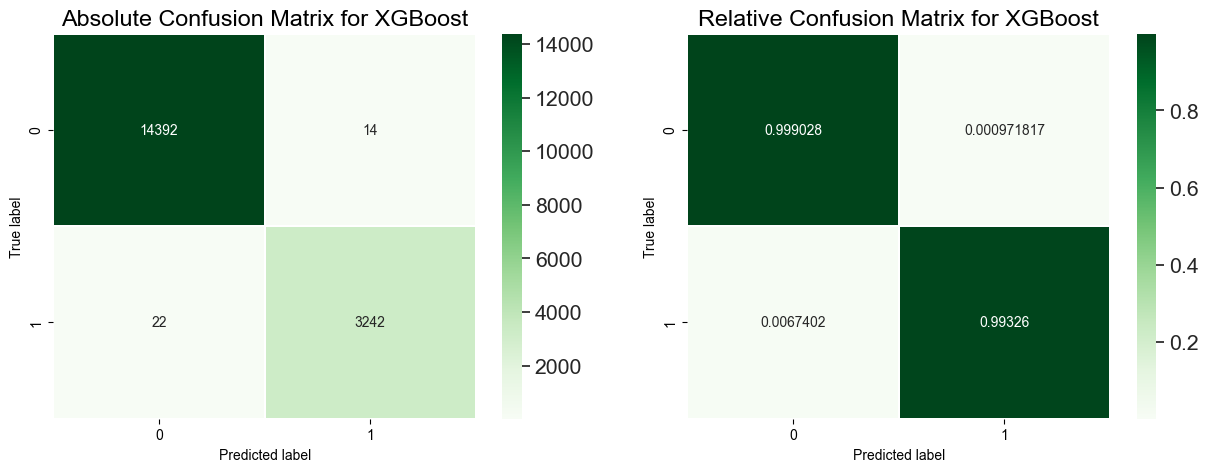

In [24]:
model = XGBoost_classification_tunned(best_hyperparams)

In [25]:

def while_XGBoost_classification_tunned(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best_results = (0,"",None,None, None)
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        #Split on train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        model = XGBClassifier(
                n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                colsample_bytree=int(best_hyperparams['colsample_bytree']),
                # subsample=int(best_hyperparams['subsample']),
                # eta=best_hyperparams['eta'],
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
        precision = precision_score(y_test, y_pred)  * 100
        recall = recall_score(y_test, y_pred)  * 100
        F1 = f1_score(y_test, y_pred)  * 100
        if best_results[0] < F1:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (F1, "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1), matrix, percentage_matrix, model)
    print("")
    print("")
    print("")
    print(best_results[0])
    print(best_results[1])
    plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]

24


99.67884997706071
99.88 & 99.51 & 99.85 & 99.68 \\


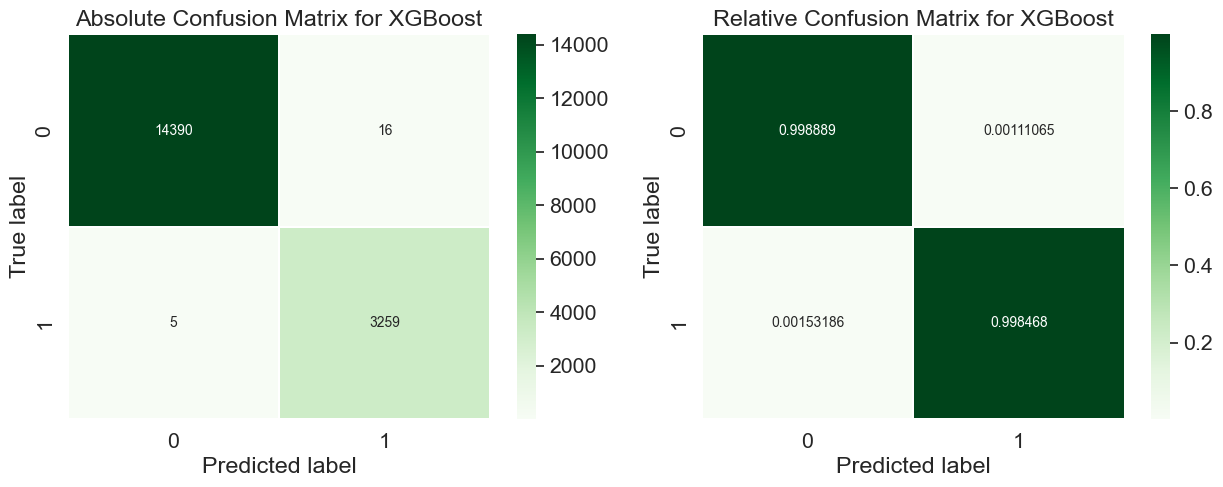

In [26]:
best_model = while_XGBoost_classification_tunned(best_hyperparams, cycles=25)

# Evaluation of model

\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}99.76 & 99.67 & 99.03 & 99.35 \\
\hline



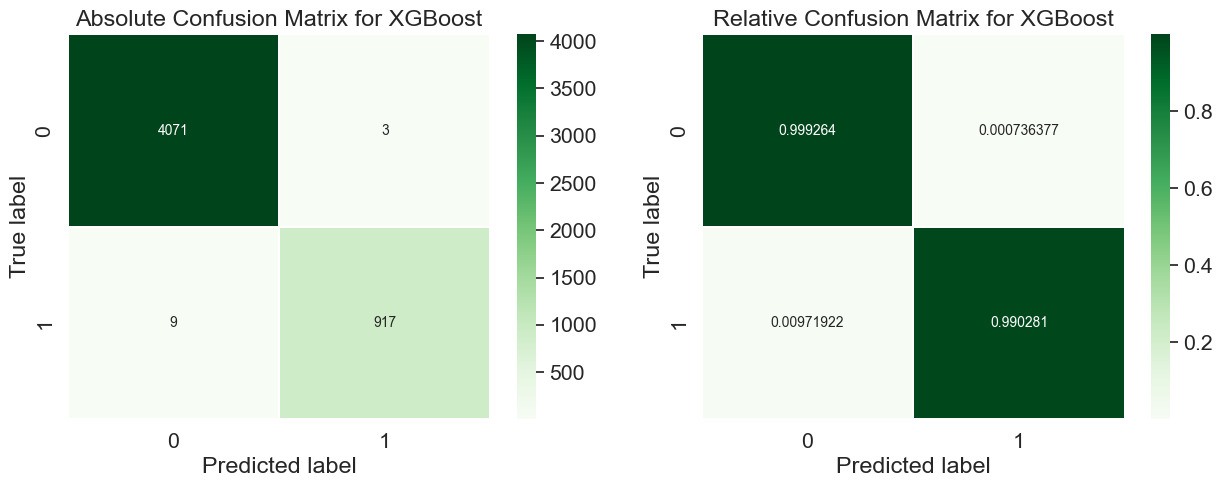

In [37]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
    

y_pred = best_model.predict(X_validation)
accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
precision = precision_score(y_validation, y_pred)  * 100
recall = recall_score(y_validation, y_pred)  * 100
F1 = f1_score(y_validation, y_pred)  * 100
                
tmp_str = ""
tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
tmp_str += "\n"
tmp_str += "\hline"
tmp_str += "\n"
print(tmp_str)

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

In [38]:
problem = "Botnet-binary"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([problem, "-", accuracy, precision, recall, F1, 0, 0, 0])

# Feature importance

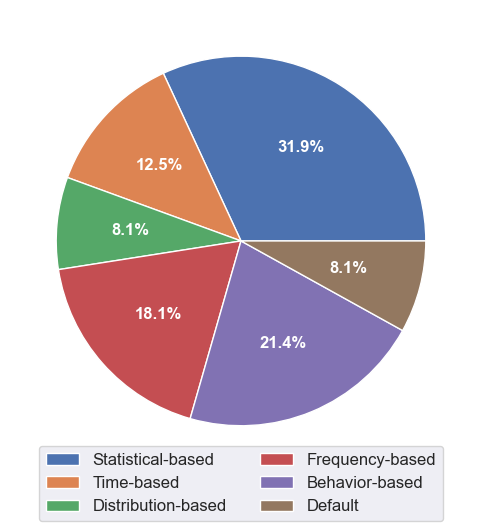

In [28]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)

f_sf = feat_importances[statistics_features].sum()
f_tf = feat_importances[time_features].sum()
f_df = feat_importances[distribution_features].sum()
f_ff = feat_importances[frequency_features].sum()
f_bf = feat_importances[behavior_features].sum()
f_df = feat_importances[default_faetures].sum()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
data = [f_sf, f_tf, f_df, f_ff, f_bf, f_df]
ingredients = ["Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based",  "Default"]
def func(pct, allvals):
    return "{:.1f}%".format(pct)
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, ingredients,
          loc="center",
          bbox_to_anchor=(0.5, 0, 0, -0.05),
          prop={'size': 12},
          ncol=2)
plt.setp(autotexts, size=12, weight="bold")
plt.show()

In [29]:
data

[0.32410914, 0.12717336, 0.08184792, 0.18369634, 0.21719658, 0.08184792]

In [30]:
feat_importances

PACKETS                  0.000000
PEARSON_SK2_SKEWNESS     0.000000
GALTON_SKEWNESS          0.000000
BENFORD_LAW_PRESENTED    0.000000
P_BENFORD                0.000000
                           ...   
PACKETS_REV              0.071589
POWER_MODE               0.076939
MEDIAN_SCALED_TIME       0.079196
MEDIAN                   0.100581
DIRECTIONS               0.111161
Length: 76, dtype: float32

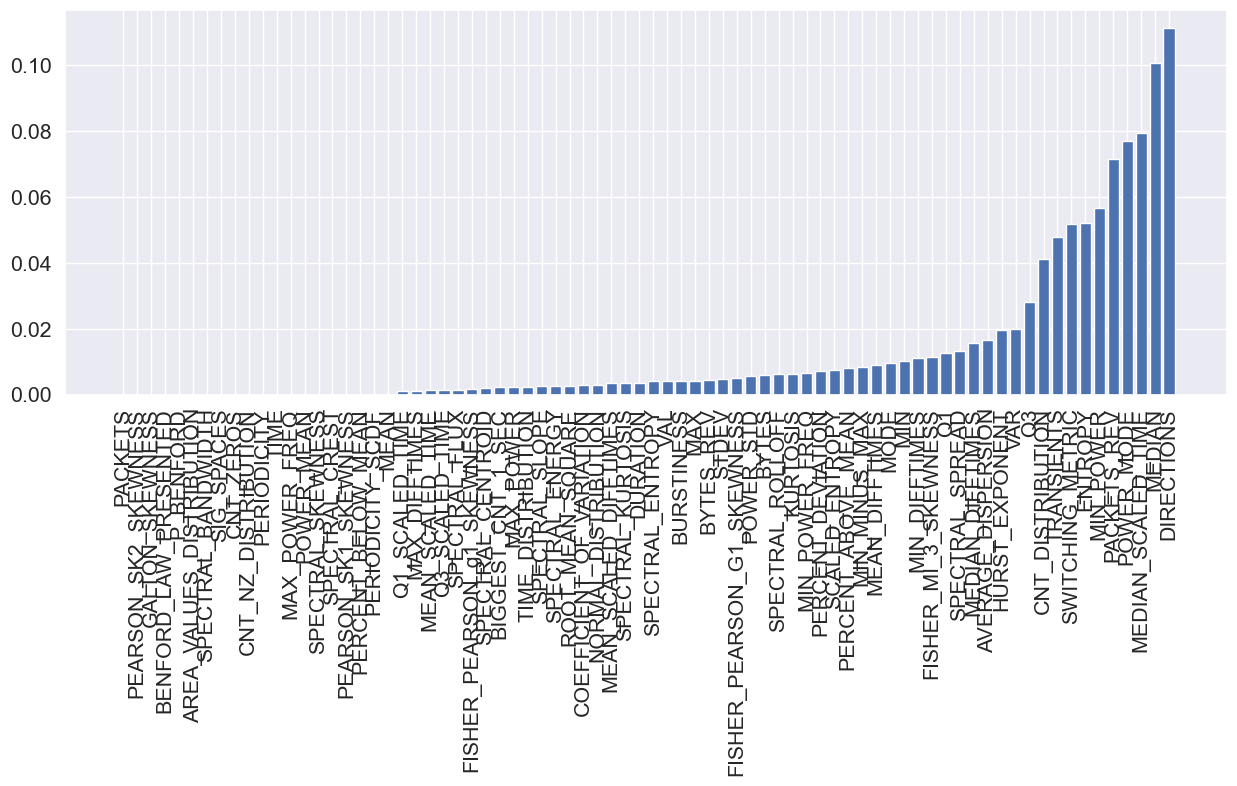

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [32]:
feat_importances.keys()

Index(['PACKETS', 'PEARSON_SK2_SKEWNESS', 'GALTON_SKEWNESS',
       'BENFORD_LAW_PRESENTED', 'P_BENFORD', 'AREA_VALUES_DISTRIBUTION',
       'SPECTRAL_BANDWIDTH', 'SIG_SPACES', 'CNT_ZEROS', 'CNT_NZ_DISTRIBUTION',
       'PERIODICITY', 'TIME', 'MAX_POWER_FREQ', 'POWER_MEAN',
       'SPECTRAL_SKEWNESS', 'SPECTRAL_CREST', 'PEARSON_SK1_SKEWNESS',
       'PERCENT_BELOW_MEAN', 'PERIODICITY_SCDF', 'MEAN', 'Q1_SCALED_TIME',
       'MAX_DIFFTIMES', 'MEAN_SCALED_TIME', 'Q3_SCALED_TIME', 'SPECTRAL_FLUX',
       'FISHER_PEARSON_g1_SKEWNESS', 'SPECTRAL_CENTROID', 'BIGGEST_CNT_1_SEC',
       'MAX_POWER', 'TIME_DISTRIBUTION', 'SPECTRAL_SLOPE', 'SPECTRAL_ENERGY',
       'ROOT_MEAN_SQUARE', 'COEFFICIENT_OF_VARIATION', 'NORMAL_DISTRIBUTION',
       'MEAN_SCALED_DIFFTIMES', 'SPECTRAL_KURTOSIS', 'DURATION',
       'SPECTRAL_ENTROPY', 'VAL', 'BURSTINESS', 'MAX', 'BYTES_REV', 'STDEV',
       'FISHER_PEARSON_G1_SKEWNESS', 'POWER_STD', 'BYTES', 'SPECTRAL_ROLLOFF',
       'KURTOSIS', 'MIN_POWER_FREQ', 'PERCENT

In [33]:
feat_importances.to_dict()

{'PACKETS': 0.0,
 'PEARSON_SK2_SKEWNESS': 0.0,
 'GALTON_SKEWNESS': 0.0,
 'BENFORD_LAW_PRESENTED': 0.0,
 'P_BENFORD': 0.0,
 'AREA_VALUES_DISTRIBUTION': 0.0,
 'SPECTRAL_BANDWIDTH': 0.0,
 'SIG_SPACES': 0.0,
 'CNT_ZEROS': 0.0,
 'CNT_NZ_DISTRIBUTION': 0.0,
 'PERIODICITY': 0.0,
 'TIME': 0.0,
 'MAX_POWER_FREQ': 0.0,
 'POWER_MEAN': 0.0,
 'SPECTRAL_SKEWNESS': 0.0,
 'SPECTRAL_CREST': 0.0,
 'PEARSON_SK1_SKEWNESS': 0.0,
 'PERCENT_BELOW_MEAN': 0.0,
 'PERIODICITY_SCDF': 0.0,
 'MEAN': 0.0,
 'Q1_SCALED_TIME': 0.001156507758423686,
 'MAX_DIFFTIMES': 0.0012333655031397939,
 'MEAN_SCALED_TIME': 0.001279137097299099,
 'Q3_SCALED_TIME': 0.00133511854801327,
 'SPECTRAL_FLUX': 0.0015704219695180655,
 'FISHER_PEARSON_g1_SKEWNESS': 0.0018422926077619195,
 'SPECTRAL_CENTROID': 0.001946461503393948,
 'BIGGEST_CNT_1_SEC': 0.0023123822174966335,
 'MAX_POWER': 0.0023247115314006805,
 'TIME_DISTRIBUTION': 0.0024147476069629192,
 'SPECTRAL_SLOPE': 0.002582751912996173,
 'SPECTRAL_ENERGY': 0.002669218461960554,
 'ROOT

# Feature selection

In [34]:
def perform_val(selected_features, cycles=25):
    best_hyperparams = tunne_together_XGBoost_classification(df_features, selected_features, verbose=False)
    
    X=df_features[selected_features]  # Features
    y=df_features['LABEL_code']  # Labels

    best = 0
    best_model = None
    for i in range(0, cycles):    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test   
        model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
        )
        model.fit(X_train, y_train)                
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
        precision = precision_score(y_test, y_pred)  * 100
        recall = recall_score(y_test, y_pred)  * 100
        F1 = f1_score(y_test, y_pred)  * 100
        if F1 > best:   
            best = F1
            best_model = model
    
    X_validation=df_validation[selected_features]  # Features
    y_validation=df_validation['LABEL_code']  # Labels

    y_pred = best_model.predict(X_validation)
    accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
    precision = precision_score(y_validation, y_pred)  * 100
    recall = recall_score(y_validation, y_pred)  * 100
    F1 = f1_score(y_validation, y_pred)  * 100
                    
    print("Test: {:.2f} {:.2f} {:.2f} {:.2f} \n".format(accuracy,precision,recall,F1))
    
    return accuracy, precision, recall, F1

In [35]:
import FEATURE_REDUCTED as FR
REPORTS = []

report = perform_val(FR.botnet_best_features)
REPORTS.append(report)
report = perform_val(FR.doh_best_features)
REPORTS.append(report)
report = perform_val(FR.dos_best_features)
REPORTS.append(report)
report = perform_val(FR.dns_malware_features)
REPORTS.append(report)
report = perform_val(FR.tor_features)
REPORTS.append(report)
report = perform_val(FR.vpn_features)
REPORTS.append(report)
report = perform_val(FR.all_best_features)
REPORTS.append(report)
report = perform_val(FR.combo_features)
REPORTS.append(report)
report = perform_val(FR.combo_2_features)
REPORTS.append(report)
report = perform_val(FR.crypto_features)
REPORTS.append(report)

100%|██████████| 100/100 [01:02<00:00,  1.59trial/s, best loss: -0.9949285384970031]
The best hyperparameters are :  

{'colsample_bytree': 0.9531361440228374, 'gamma': 3.5053478862838263, 'max_depth': 14.0, 'min_child_weight': 5.0, 'n_estimators': 260.0, 'reg_alpha': 0.0, 'reg_lambda': 0.6356982236437059}
Test: 99.84 99.68 99.46 99.57 

100%|██████████| 100/100 [00:53<00:00,  1.88trial/s, best loss: -0.9952446694278265]
The best hyperparameters are :  

{'colsample_bytree': 0.40556788540178146, 'gamma': 2.444491583415006, 'max_depth': 14.0, 'min_child_weight': 5.0, 'n_estimators': 280.0, 'reg_alpha': 17.0, 'reg_lambda': 0.3599478848796673}
Test: 99.78 99.46 99.35 99.41 

100%|██████████| 100/100 [01:08<00:00,  1.45trial/s, best loss: -0.9932515337423312]
The best hyperparameters are :  

{'colsample_bytree': 0.024709163740587112, 'gamma': 4.70082713804457, 'max_depth': 30.0, 'min_child_weight': 15.0, 'n_estimators': 300.0, 'reg_alpha': 1.0, 'reg_lambda': 0.5654082487809409}
Test: 99.7

In [36]:
import csv

problem = "Botnet-binary"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    for report, f_set in zip(REPORTS, FR.FEATURE_SETS):
        writer.writerow([problem, f_set, report[0], report[1], report[2], report[3], 0, 0, 0])